In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_openml
import warnings
warnings.filterwarnings('ignore')

In [2]:
# For reproducibility
np.random.seed(42)

# 1. Data Loading and Preprocessing

In [4]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
X = X.astype('float32')
y = y.astype('int')

# Normalize pixel values
X /= 255.0

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Data shapes: X_train {X_train.shape}, X_val {X_val.shape}, X_test {X_test.shape}")

Data shapes: X_train (44800, 784), X_val (11200, 784), X_test (14000, 784)


In [8]:
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


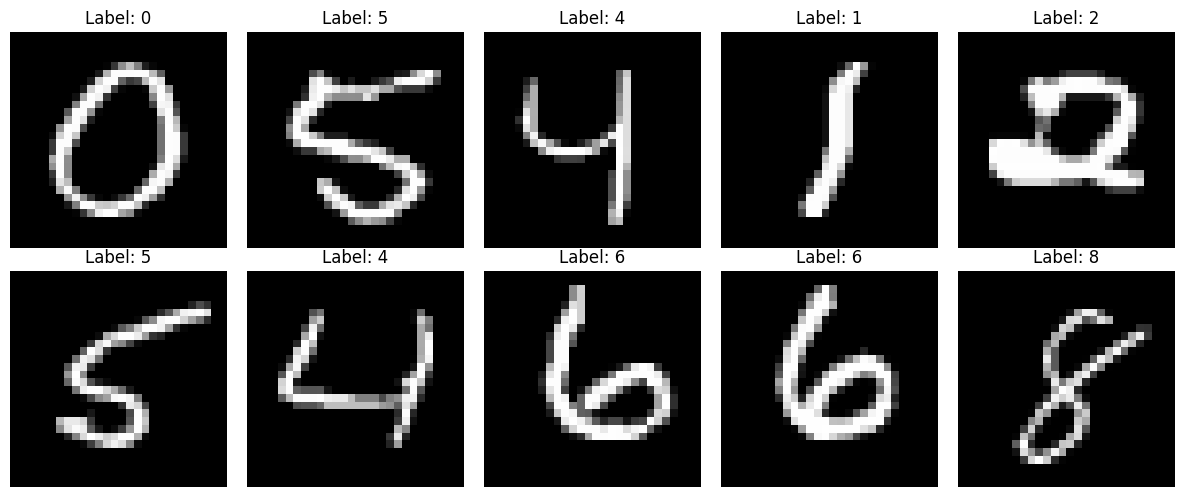

In [10]:
# Visualize data
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train.iloc[i].values.reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train.iloc[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# 2. Neural Network from Scratch

In [14]:
class NeuralNetworkNumpy:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.01, use_dropout=False, dropout_rate=0.2,
                 use_l2=False, l2_lambda=0.001, use_batch_norm=False):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.use_dropout = use_dropout
        self.dropout_rate = dropout_rate
        self.use_l2 = use_l2
        self.l2_lambda = l2_lambda
        self.use_batch_norm = use_batch_norm

        # Initialize weights and biases
        self.parameters = {}

        # Input layer to first hidden layer
        self.parameters['W1'] = np.random.randn(input_size, hidden_sizes[0]) * np.sqrt(2. / input_size)
        self.parameters['b1'] = np.zeros((1, hidden_sizes[0]))

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.parameters[f'W{i+1}'] = np.random.randn(hidden_sizes[i-1], hidden_sizes[i]) * np.sqrt(2. / hidden_sizes[i-1])
            self.parameters[f'b{i+1}'] = np.zeros((1, hidden_sizes[i]))

        # Last hidden layer to output layer
        self.parameters[f'W{len(hidden_sizes)+1}'] = np.random.randn(hidden_sizes[-1], output_size) * np.sqrt(2. / hidden_sizes[-1])
        self.parameters[f'b{len(hidden_sizes)+1}'] = np.zeros((1, output_size))

        # Batch normalization parameters
        if self.use_batch_norm:
            for i in range(len(hidden_sizes)):
                self.parameters[f'gamma{i+1}'] = np.ones((1, hidden_sizes[i]))
                self.parameters[f'beta{i+1}'] = np.zeros((1, hidden_sizes[i]))
                # Running means and variances (for inference)
                self.parameters[f'running_mean{i+1}'] = np.zeros((1, hidden_sizes[i]))
                self.parameters[f'running_var{i+1}'] = np.zeros((1, hidden_sizes[i]))

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return Z > 0

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def batch_norm_forward(self, X, gamma, beta, layer_idx, is_training=True, epsilon=1e-8):
        if is_training:
            # Calculate batch mean and variance
            batch_mean = np.mean(X, axis=0, keepdims=True)
            batch_var = np.var(X, axis=0, keepdims=True)

            # Update running statistics for inference
            momentum = 0.9
            self.parameters[f'running_mean{layer_idx}'] = momentum * self.parameters[f'running_mean{layer_idx}'] + (1 - momentum) * batch_mean
            self.parameters[f'running_var{layer_idx}'] = momentum * self.parameters[f'running_var{layer_idx}'] + (1 - momentum) * batch_var

            # Normalize
            X_norm = (X - batch_mean) / np.sqrt(batch_var + epsilon)

            # Store for backward pass
            self.cache[f'batch_norm{layer_idx}'] = (X, X_norm, batch_mean, batch_var, gamma, beta, epsilon)
        else:
            # Use running statistics for inference
            X_norm = (X - self.parameters[f'running_mean{layer_idx}']) / np.sqrt(self.parameters[f'running_var{layer_idx}'] + epsilon)

        # Scale and shift
        out = gamma * X_norm + beta

        return out

    def forward(self, X, is_training=True):
        self.cache = {}
        self.cache['A0'] = X
        A = X
        num_layers = len(self.hidden_sizes) + 1

        # Forward propagation through all layers except the output layer
        for i in range(1, num_layers):
            Z = np.dot(A, self.parameters[f'W{i}']) + self.parameters[f'b{i}']
            self.cache[f'Z{i}'] = Z

            # Apply batch normalization if enabled
            if self.use_batch_norm and i < num_layers:
                Z = self.batch_norm_forward(Z, self.parameters[f'gamma{i}'], self.parameters[f'beta{i}'], i, is_training)

            A = self.relu(Z)
            self.cache[f'A{i}'] = A

            # Apply dropout if enabled and in training mode
            if self.use_dropout and is_training:
                dropout_mask = np.random.rand(*A.shape) > self.dropout_rate
                A *= dropout_mask / (1 - self.dropout_rate)  # Scale by dropout rate
                self.cache[f'dropout_mask{i}'] = dropout_mask

        # Output layer
        Z = np.dot(A, self.parameters[f'W{num_layers}']) + self.parameters[f'b{num_layers}']
        self.cache[f'Z{num_layers}'] = Z
        A = self.softmax(Z)
        self.cache[f'A{num_layers}'] = A

        return A

    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        y_true_one_hot = np.zeros((m, self.output_size))
        y_true_one_hot[np.arange(m), y_true] = 1

        # Cross-entropy loss
        log_likelihood = -np.log(y_pred[np.arange(m), y_true] + 1e-8)
        loss = np.sum(log_likelihood) / m

        # Add L2 regularization if enabled
        if self.use_l2:
            l2_regularization = 0
            num_layers = len(self.hidden_sizes) + 1
            for i in range(1, num_layers + 1):
                l2_regularization += np.sum(np.square(self.parameters[f'W{i}']))
            loss += (self.l2_lambda / (2*m)) * l2_regularization

        return loss

    def backward(self, y_true):
        m = y_true.shape[0]
        y_true_one_hot = np.zeros((m, self.output_size))
        y_true_one_hot[np.arange(m), y_true] = 1

        gradients = {}
        num_layers = len(self.hidden_sizes) + 1

        # Output layer gradient
        dA = self.cache[f'A{num_layers}'] - y_true_one_hot

        # Backward pass through all layers
        for i in range(num_layers, 0, -1):
            # Calculate gradients for the current layer
            if i == num_layers:  # Output layer
                dZ = dA
            else:  # Hidden layers
                dZ = dA * self.relu_derivative(self.cache[f'Z{i}'])

                # Apply dropout gradients if enabled
                if self.use_dropout:
                    dZ *= self.cache[f'dropout_mask{i}'] / (1 - self.dropout_rate)

                # Apply batch norm gradients if enabled
                if self.use_batch_norm:
                    # This is a simplified batch norm backward pass
                    # In a complete implementation, we would compute gradients for gamma and beta too
                    pass

            # Calculate gradients for weights and biases
            dW = np.dot(self.cache[f'A{i-1}'].T, dZ) / m
            db = np.sum(dZ, axis=0, keepdims=True) / m

            # Add L2 regularization gradient if enabled
            if self.use_l2:
                dW += (self.l2_lambda / m) * self.parameters[f'W{i}']

            gradients[f'dW{i}'] = dW
            gradients[f'db{i}'] = db

            # Calculate gradient for the previous layer
            if i > 1:
                dA = np.dot(dZ, self.parameters[f'W{i}'].T)

        # Update parameters
        for i in range(1, num_layers + 1):
            self.parameters[f'W{i}'] -= self.learning_rate * gradients[f'dW{i}']
            self.parameters[f'b{i}'] -= self.learning_rate * gradients[f'db{i}']

            # Update batch normalization parameters if enabled
            if self.use_batch_norm and i < num_layers:
                # In a complete implementation, we would update gamma and beta here
                pass

    def predict(self, X):
        # Forward pass in inference mode
        A = self.forward(X, is_training=False)
        return np.argmax(A, axis=1)

    def train(self, X_train, y_train, X_val, y_val, batch_size=32, epochs=10, early_stopping_patience=5):
        m = X_train.shape[0]
        num_batches = int(np.ceil(m / batch_size))

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            # Shuffle training data
            indices = np.random.permutation(m)
            X_train_shuffled = X_train.iloc[indices]
            y_train_shuffled = y_train.iloc[indices]

            epoch_train_loss = 0

            for i in range(num_batches):
                start_idx = i * batch_size
                end_idx = min((i + 1) * batch_size, m)

                X_batch = X_train_shuffled[start_idx:end_idx]
                y_batch = y_train_shuffled[start_idx:end_idx]

                # Forward pass
                y_pred = self.forward(X_batch)

                # Compute loss
                batch_loss = self.compute_loss(y_pred, y_batch)
                epoch_train_loss += batch_loss * (end_idx - start_idx) / m

                # Backward pass
                self.backward(y_batch)

            # Calculate training accuracy
            y_train_pred = self.predict(X_train)
            train_accuracy = np.mean(y_train_pred == y_train)

            # Calculate validation loss and accuracy
            y_val_pred_probs = self.forward(X_val, is_training=False)
            val_loss = self.compute_loss(y_val_pred_probs, y_val)
            y_val_pred = np.argmax(y_val_pred_probs, axis=1)
            val_accuracy = np.mean(y_val_pred == y_val)

            # Store metrics
            train_losses.append(epoch_train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping triggered after {epoch+1} epochs")
                    break

        return {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }

In [15]:
sample_size = 5000
X_train_sample = X_train[:sample_size]
y_train_sample = y_train[:sample_size]
X_val_sample = X_val[:1000]
y_val_sample = y_val[:1000]

# Initialize and train the neural network
input_size = 784  # 28x28 pixels
hidden_sizes = [128, 64]  # Two hidden layers
output_size = 10  # 10 classes (digits 0-9)

numpy_nn = NeuralNetworkNumpy(
    input_size=input_size,
    hidden_sizes=hidden_sizes,
    output_size=output_size,
    learning_rate=0.01,
    use_dropout=True,
    dropout_rate=0.2,
    use_l2=True,
    l2_lambda=0.001,
    use_batch_norm=True
)

In [17]:
# Train the model
numpy_history = numpy_nn.train(
    X_train_sample, y_train_sample,
    X_val_sample, y_val_sample,
    batch_size=32,
    epochs=10,
    early_stopping_patience=3
)

Epoch 1/10, Train Loss: 0.9874, Val Loss: 0.7600, Train Acc: 0.8114, Val Acc: 0.7940
Epoch 2/10, Train Loss: 0.9261, Val Loss: 0.7151, Train Acc: 0.8270, Val Acc: 0.8150
Epoch 3/10, Train Loss: 0.8966, Val Loss: 0.7513, Train Acc: 0.8184, Val Acc: 0.7990
Epoch 4/10, Train Loss: 0.8804, Val Loss: 0.7372, Train Acc: 0.8188, Val Acc: 0.8060
Epoch 5/10, Train Loss: 0.8562, Val Loss: 0.6810, Train Acc: 0.8400, Val Acc: 0.8280
Epoch 6/10, Train Loss: 0.8393, Val Loss: 0.6706, Train Acc: 0.8394, Val Acc: 0.8280
Epoch 7/10, Train Loss: 0.8339, Val Loss: 0.6787, Train Acc: 0.8398, Val Acc: 0.8180
Epoch 8/10, Train Loss: 0.8347, Val Loss: 0.6605, Train Acc: 0.8522, Val Acc: 0.8440
Epoch 9/10, Train Loss: 0.8124, Val Loss: 0.6494, Train Acc: 0.8542, Val Acc: 0.8430
Epoch 10/10, Train Loss: 0.7970, Val Loss: 0.6369, Train Acc: 0.8564, Val Acc: 0.8320


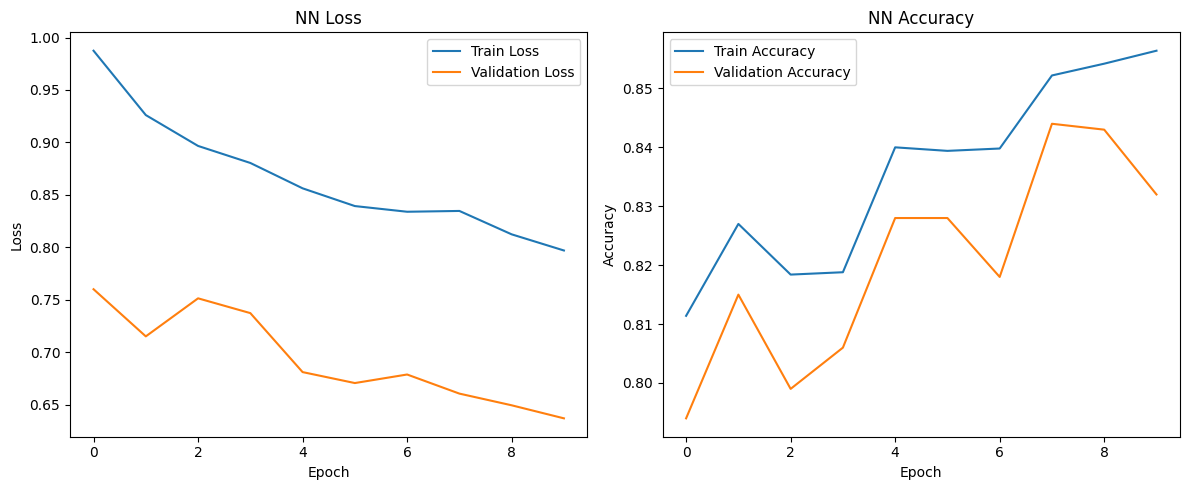

In [19]:
# Visualize training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(numpy_history['train_losses'], label='Train Loss')
plt.plot(numpy_history['val_losses'], label='Validation Loss')
plt.title('NN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(numpy_history['train_accuracies'], label='Train Accuracy')
plt.plot(numpy_history['val_accuracies'], label='Validation Accuracy')
plt.title('NN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# Test the model
numpy_predictions = numpy_nn.predict(X_test[:1000])
numpy_test_accuracy = np.mean(numpy_predictions == y_test[:1000])
print(f"NumPy Neural Network Test Accuracy: {numpy_test_accuracy:.4f}")

NumPy Neural Network Test Accuracy: 0.8520


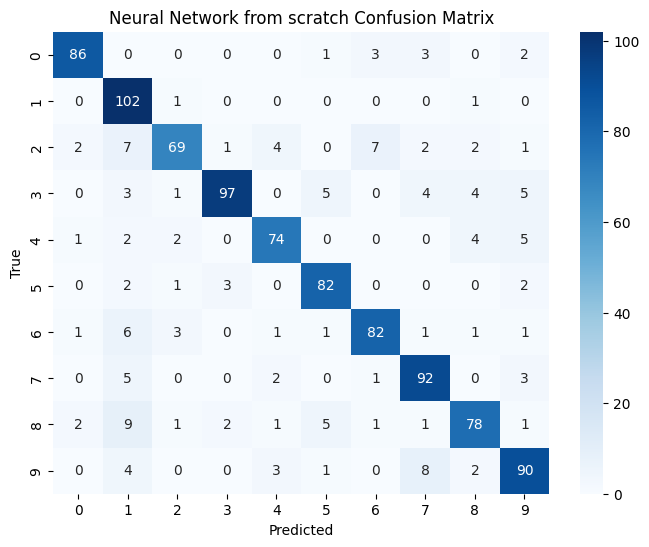

In [21]:
# Confusion matrix
numpy_cm = confusion_matrix(y_test[:1000], numpy_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(numpy_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Neural Network from scratch Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 3. Neural Network using PyTorch

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [24]:
# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.LongTensor(y_train.values)
X_val_tensor = torch.FloatTensor(X_val.values)
y_val_tensor = torch.LongTensor(y_val.values)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.LongTensor(y_test.values)

In [25]:
# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [26]:
# The PyTorch neural network
class PyTorchNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.2, use_batch_norm=True):
        super(PyTorchNN, self).__init__()

        self.use_batch_norm = use_batch_norm
        layers = []

        # Input layer to first hidden layer
        if use_batch_norm:
            layers.append(nn.Linear(input_size, hidden_sizes[0], bias=False))
            layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        else:
            layers.append(nn.Linear(input_size, hidden_sizes[0]))

        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))

        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            if use_batch_norm:
                layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1], bias=False))
                layers.append(nn.BatchNorm1d(hidden_sizes[i+1]))
            else:
                layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))

        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [27]:
# Function to train the PyTorch model
def train_pytorch_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None,
                        num_epochs=10, early_stopping_patience=5, device='cpu'):

    # Move model to device
    model = model.to(device)

    # Training history
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Early stopping
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate epoch statistics
        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Track statistics
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate epoch statistics
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Update learning rate if scheduler is provided
        if scheduler is not None:
            scheduler.step(val_loss)

        # Print statistics
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model weights
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                # Load best model weights
                model.load_state_dict(best_model_state)
                break

    # Return the best model and training history
    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

In [28]:
# Function to test the PyTorch model
def test_pytorch_model(model, test_loader, device='cpu'):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    return accuracy, all_predictions, all_labels

In [29]:
# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Choose device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [30]:
# Create the PyTorch model
pytorch_model = PyTorchNN(
    input_size=784,
    hidden_sizes=[256, 128],
    output_size=10,
    dropout_rate=0.3,
    use_batch_norm=True
)

In [31]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

In [32]:
# Train the model
pytorch_model, pytorch_history = train_pytorch_model(
    model=pytorch_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=10,
    early_stopping_patience=5,
    device=device
)

Epoch 1/10, Train Loss: 0.3357, Val Loss: 0.1321, Train Acc: 0.9071, Val Acc: 0.9613
Epoch 2/10, Train Loss: 0.1641, Val Loss: 0.0995, Train Acc: 0.9500, Val Acc: 0.9697
Epoch 3/10, Train Loss: 0.1296, Val Loss: 0.0838, Train Acc: 0.9608, Val Acc: 0.9744
Epoch 4/10, Train Loss: 0.1102, Val Loss: 0.0765, Train Acc: 0.9651, Val Acc: 0.9773
Epoch 5/10, Train Loss: 0.0965, Val Loss: 0.0764, Train Acc: 0.9693, Val Acc: 0.9754
Epoch 6/10, Train Loss: 0.0881, Val Loss: 0.0718, Train Acc: 0.9721, Val Acc: 0.9772
Epoch 7/10, Train Loss: 0.0811, Val Loss: 0.0766, Train Acc: 0.9733, Val Acc: 0.9762
Epoch 8/10, Train Loss: 0.0756, Val Loss: 0.0658, Train Acc: 0.9760, Val Acc: 0.9809
Epoch 9/10, Train Loss: 0.0698, Val Loss: 0.0643, Train Acc: 0.9773, Val Acc: 0.9817
Epoch 10/10, Train Loss: 0.0656, Val Loss: 0.0614, Train Acc: 0.9794, Val Acc: 0.9819


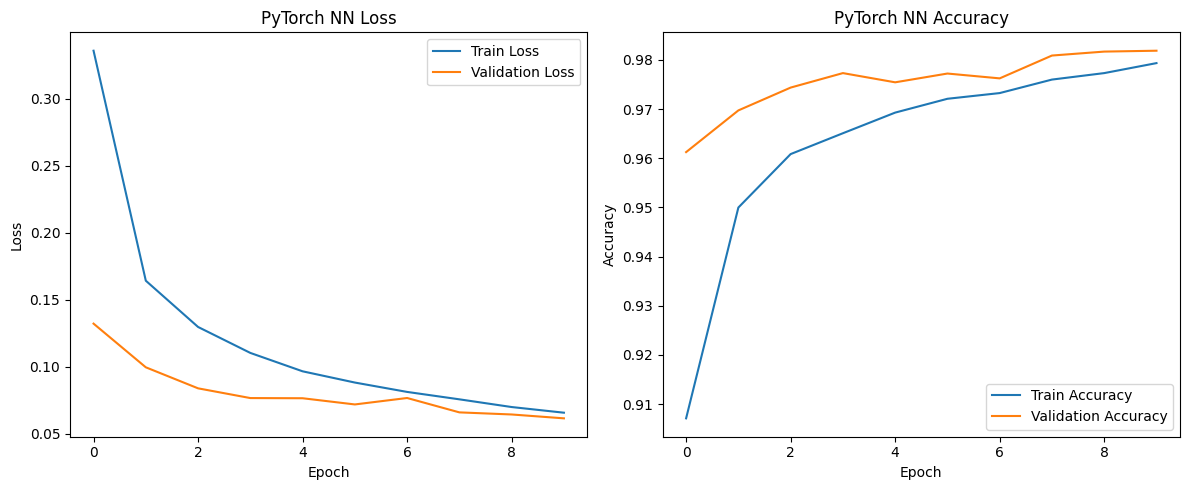

In [33]:
# Visualize training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(pytorch_history['train_losses'], label='Train Loss')
plt.plot(pytorch_history['val_losses'], label='Validation Loss')
plt.title('PyTorch NN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(pytorch_history['train_accuracies'], label='Train Accuracy')
plt.plot(pytorch_history['val_accuracies'], label='Validation Accuracy')
plt.title('PyTorch NN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
# Test the model
pytorch_accuracy, pytorch_predictions, pytorch_true_labels = test_pytorch_model(
    model=pytorch_model,
    test_loader=test_loader,
    device=device
)

Test Accuracy: 0.9792


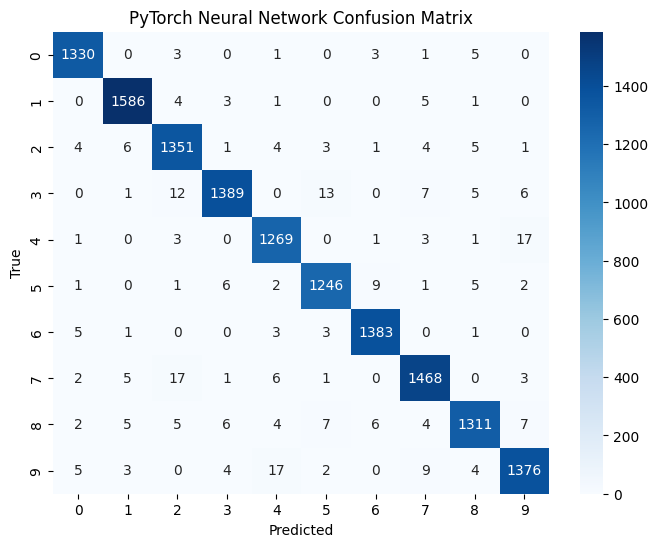

In [35]:
# Confusion matrix
pytorch_cm = confusion_matrix(pytorch_true_labels, pytorch_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(pytorch_cm, annot=True, fmt='d', cmap='Blues')
plt.title('PyTorch Neural Network Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [37]:
# Visualize some predictions
plt.figure(figsize=(12, 8))
num_samples = 10
for i in range(num_samples):
    # Get a sample from the test set
    image = X_test.iloc[i].reshape(28, 28)
    true_label = y_test.iloc[i]

    # Make prediction
    with torch.no_grad():
        input_tensor = torch.FloatTensor(X_test[i]).unsqueeze(0).to(device)
        output = pytorch_model(input_tensor)
        _, predicted = torch.max(output.data, 1)
        predicted_label = predicted.item()

    # Calculate softmax probabilities
    softmax = nn.Softmax(dim=1)
    probabilities = softmax(output).cpu().numpy()[0]

    # Plot the image
    plt.subplot(2, num_samples, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f"True: {true_label}")
    plt.axis('off')

    # Plot the prediction probabilities
    plt.subplot(2, num_samples, i+1+num_samples)
    plt.bar(np.arange(10), probabilities)
    plt.title(f"Pred: {predicted_label}")
    plt.xticks(np.arange(10))
plt.tight_layout()
plt.show()

AttributeError: 'Series' object has no attribute 'reshape'

<Figure size 1200x800 with 0 Axes>

# 4. Neural Network using TensorFlow

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [40]:
# Set random seeds
tf.random.set_seed(42)

# Reshape data for TensorFlow
X_train_tf = X_train.to_numpy().reshape(-1, 784)
X_val_tf = X_val.to_numpy().reshape(-1, 784)
X_test_tf = X_test.to_numpy().reshape(-1, 784)

In [41]:
# Create a simple neural network using Keras Sequential API
def create_tensorflow_model(hidden_sizes=[256, 128], dropout_rate=0.3, use_batch_norm=True, l2_lambda=0.0001):
    model = Sequential()

    # Input layer to first hidden layer
    model.add(Dense(hidden_sizes[0], input_shape=(784,), kernel_regularizer=l2(l2_lambda)))
    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(Dropout(dropout_rate))

    # Hidden layers
    for units in hidden_sizes[1:]:
        model.add(Dense(units, kernel_regularizer=l2(l2_lambda)))
        if use_batch_norm:
            model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(10, activation='softmax'))

    return model

In [42]:
# Create TensorFlow model
tf_model = create_tensorflow_model(
    hidden_sizes=[256, 128],
    dropout_rate=0.3,
    use_batch_norm=True,
    l2_lambda=0.0001
)

In [43]:
# Compile the model
tf_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [44]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

In [45]:
# Train the model
tf_history = tf_model.fit(
    X_train_tf, y_train,
    validation_data=(X_val_tf, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8159 - loss: 0.6713 - val_accuracy: 0.9568 - val_loss: 0.1973 - learning_rate: 0.0010
Epoch 2/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9401 - loss: 0.2481 - val_accuracy: 0.9646 - val_loss: 0.1636 - learning_rate: 0.0010
Epoch 3/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9513 - loss: 0.2030 - val_accuracy: 0.9682 - val_loss: 0.1525 - learning_rate: 0.0010
Epoch 4/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9617 - loss: 0.1774 - val_accuracy: 0.9722 - val_loss: 0.1404 - learning_rate: 0.0010
Epoch 5/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9660 - loss: 0.1622 - val_accuracy: 0.9730 - val_loss: 0.1366 - learning_rate: 0.0010
Epoch 6/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9658 - loss: 0.1593 - val_accuracy: 0.9778 - val_loss: 0.1329 - learning_rate: 0.0010
Epoch 7/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9712 - loss: 0.1452 - 

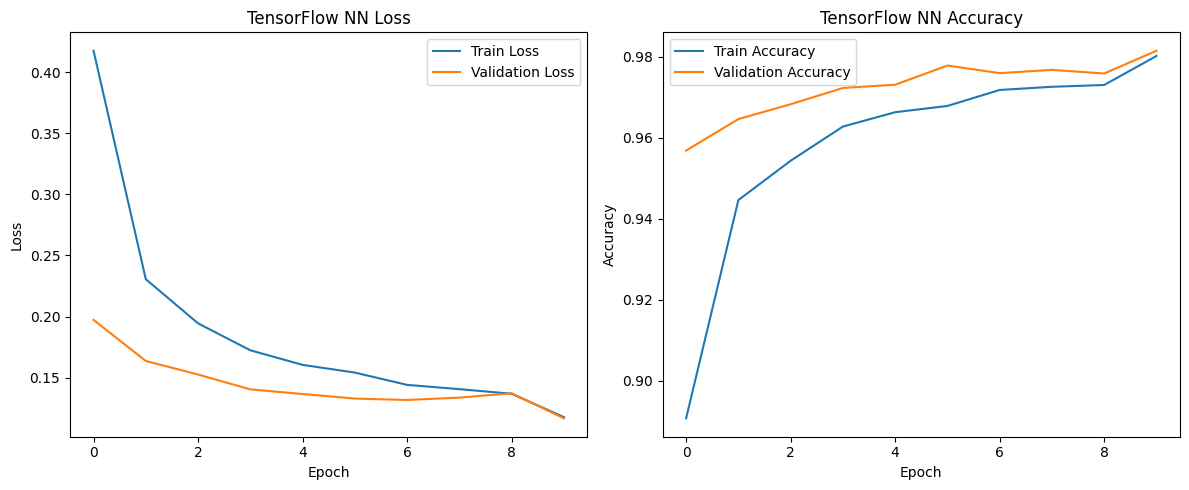

In [46]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(tf_history.history['loss'], label='Train Loss')
plt.plot(tf_history.history['val_loss'], label='Validation Loss')
plt.title('TensorFlow NN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tf_history.history['accuracy'], label='Train Accuracy')
plt.plot(tf_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('TensorFlow NN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
# Evaluate the model on test data
tf_test_loss, tf_test_accuracy = tf_model.evaluate(X_test_tf, y_test, verbose=0)
print(f"TensorFlow Neural Network Test Accuracy: {tf_test_accuracy:.4f}")

TensorFlow Neural Network Test Accuracy: 0.9793


In [48]:
# Make predictions
tf_predictions = tf_model.predict(X_test_tf)
tf_predictions_classes = np.argmax(tf_predictions, axis=1)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


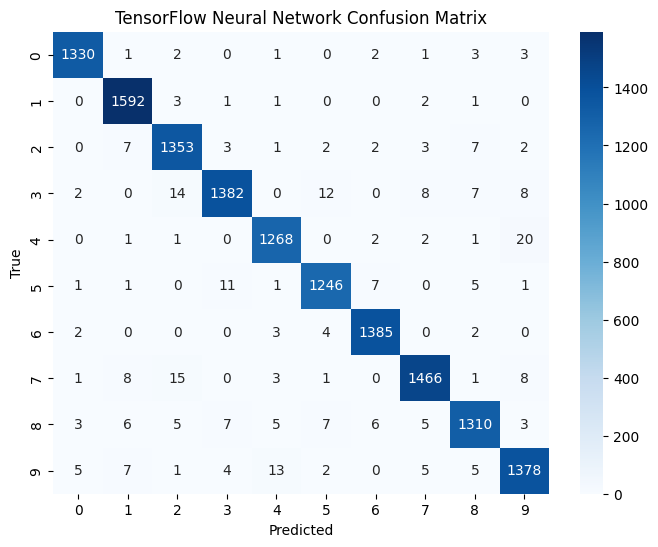

In [49]:
# Confusion matrix
tf_cm = confusion_matrix(y_test, tf_predictions_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(tf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('TensorFlow Neural Network Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [50]:
# Visualize some predictions with TensorFlow model
plt.figure(figsize=(12, 8))
num_samples = 10
for i in range(num_samples):
    # Get a sample from the test set
    image = X_test[i].reshape(28, 28)
    true_label = y_test[i]

    # Make prediction
    input_sample = X_test[i].reshape(1, 784)
    prediction = tf_model.predict(input_sample)
    predicted_label = np.argmax(prediction)

    # Plot the image
    plt.subplot(2, num_samples, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f"True: {true_label}")
    plt.axis('off')

    # Plot the prediction probabilities
    plt.subplot(2, num_samples, i+1+num_samples)
    plt.bar(np.arange(10), prediction[0])
    plt.title(f"Pred: {predicted_label}")
    plt.xticks(np.arange(10))
plt.tight_layout()
plt.show()

KeyError: 0

<Figure size 1200x800 with 0 Axes>

# 5. Regularization Techniques

In [51]:
# Function to create models with different regularization settings
def create_model_with_regularization(regularization_type=None, **kwargs):
    model = Sequential()

    # Default parameters
    l2_lambda = kwargs.get('l2_lambda', 0.0001)
    dropout_rate = kwargs.get('dropout_rate', 0.3)
    use_batch_norm = kwargs.get('use_batch_norm', False)

    # Input layer
    if regularization_type == 'l2':
        model.add(Dense(128, input_shape=(784,), kernel_regularizer=l2(l2_lambda), activation='relu'))
    else:
        model.add(Dense(128, input_shape=(784,), activation='relu'))

    # Add batch normalization if specified
    if regularization_type == 'batch_norm' or use_batch_norm:
        model.add(BatchNormalization())

    # Add dropout if specified
    if regularization_type == 'dropout':
        model.add(Dropout(dropout_rate))

    # Hidden layer
    if regularization_type == 'l2':
        model.add(Dense(64, kernel_regularizer=l2(l2_lambda), activation='relu'))
    else:
        model.add(Dense(64, activation='relu'))

    # Add batch normalization if specified
    if regularization_type == 'batch_norm' or use_batch_norm:
        model.add(BatchNormalization())

    # Add dropout if specified
    if regularization_type == 'dropout':
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(10, activation='softmax'))

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [53]:
# Create and train models with different regularization techniques
regularization_techniques = ['none', 'l2', 'dropout', 'batch_norm']
results = {}

for tech in regularization_techniques:
    print(f"\nTraining model with {tech} regularization...")

    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=0
    )

    # Create and train model
    if tech == 'none':
        model = create_model_with_regularization()
    else:
        model = create_model_with_regularization(regularization_type=tech)

    # Train model on a smaller subset for demonstration
    history = model.fit(
        X_train_tf[:10000], y_train[:10000],
        validation_data=(X_val_tf, y_val),
        epochs=5,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate model
    val_loss, val_acc = model.evaluate(X_val_tf, y_val, verbose=0)
    print(f"{tech.capitalize()} regularization - Validation Accuracy: {val_acc:.4f}")

    # Store results
    results[tech] = {
        'model': model,
        'history': history,
        'val_accuracy': val_acc
    }


Training model with none regularization...
None regularization - Validation Accuracy: 0.9438

Training model with l2 regularization...
L2 regularization - Validation Accuracy: 0.9493

Training model with dropout regularization...
Dropout regularization - Validation Accuracy: 0.9370

Training model with batch_norm regularization...
Batch_norm regularization - Validation Accuracy: 0.9521


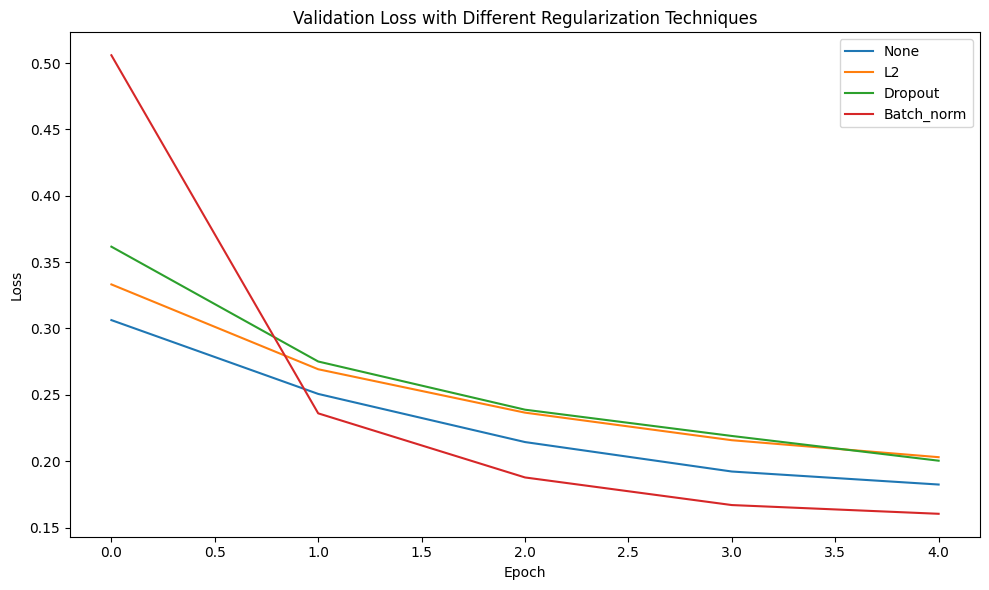

In [54]:
# Plot validation losses for different regularization techniques
plt.figure(figsize=(10, 6))
for tech in regularization_techniques:
    plt.plot(results[tech]['history'].history['val_loss'], label=f"{tech.capitalize()}")
plt.title('Validation Loss with Different Regularization Techniques')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

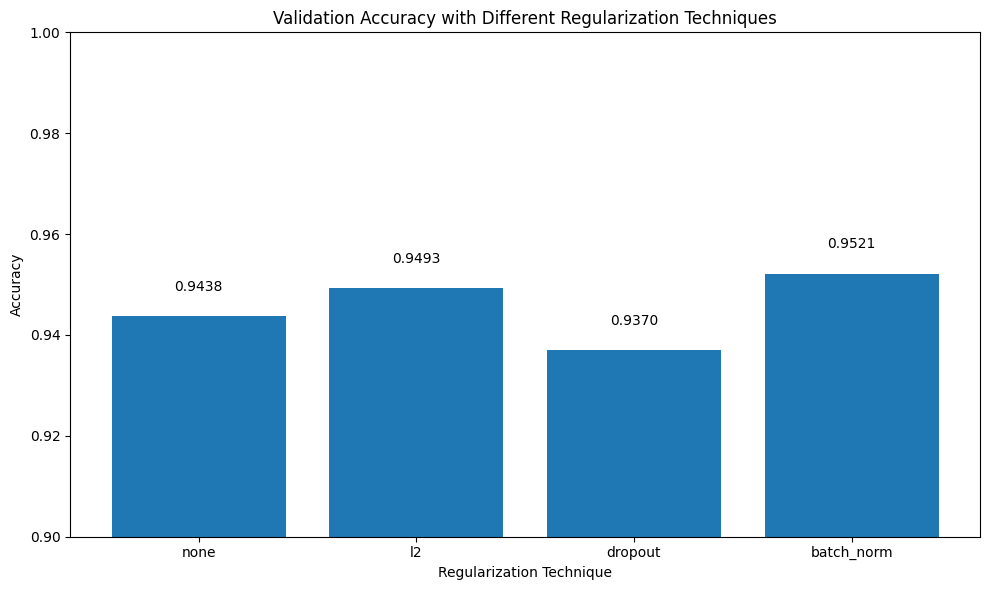

In [55]:
# Plot validation accuracies
val_accuracies = [results[tech]['val_accuracy'] for tech in regularization_techniques]

plt.figure(figsize=(10, 6))
plt.bar(regularization_techniques, val_accuracies)
plt.title('Validation Accuracy with Different Regularization Techniques')
plt.xlabel('Regularization Technique')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)  # Adjust as needed
for i, v in enumerate(val_accuracies):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()

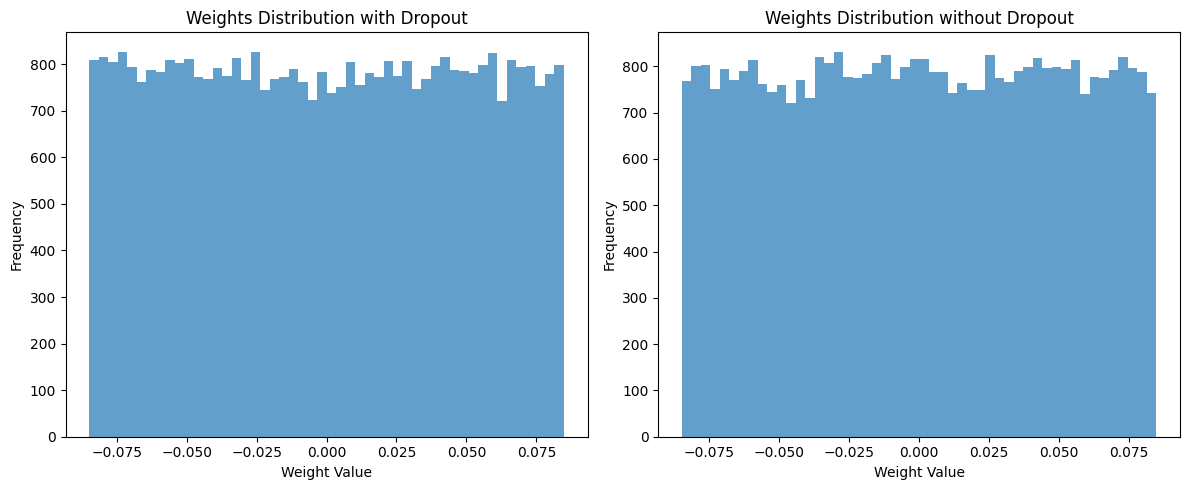

In [56]:
# Visualization of Dropout effect
# Create a small model with and without dropout to visualize the effect
dropout_model = tf.keras.Sequential([
    Dense(50, input_shape=(784,), activation='relu'),
    Dropout(0.5),  # 50% dropout
    Dense(10, activation='softmax')
])

no_dropout_model = tf.keras.Sequential([
    Dense(50, input_shape=(784,), activation='relu'),
    Dense(10, activation='softmax')
])

# Extract and visualize weights from the first layer
dropout_weights = dropout_model.layers[0].get_weights()[0]
no_dropout_weights = no_dropout_model.layers[0].get_weights()[0]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(dropout_weights.flatten(), bins=50, alpha=0.7)
plt.title('Weights Distribution with Dropout')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(no_dropout_weights.flatten(), bins=50, alpha=0.7)
plt.title('Weights Distribution without Dropout')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7061 - loss: 0.9748 - val_accuracy: 0.9030 - val_loss: 0.3278
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9202 - loss: 0.2521 - val_accuracy: 0.9370 - val_loss: 0.2317
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9513 - loss: 0.1569 - val_accuracy: 0.9480 - val_loss: 0.1900
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9695 - loss: 0.0978 - val_accuracy: 0.9470 - val_loss: 0.1769
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9784 - loss: 0.0660 - val_accuracy: 0.9450 - val_loss: 0.1899
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9885 - loss: 0.0378 - val_accuracy: 0.9500 - val_loss: 0.1907
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9944 - loss: 0.0223 - val_accuracy: 0.9410 - val_loss: 0.2337
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


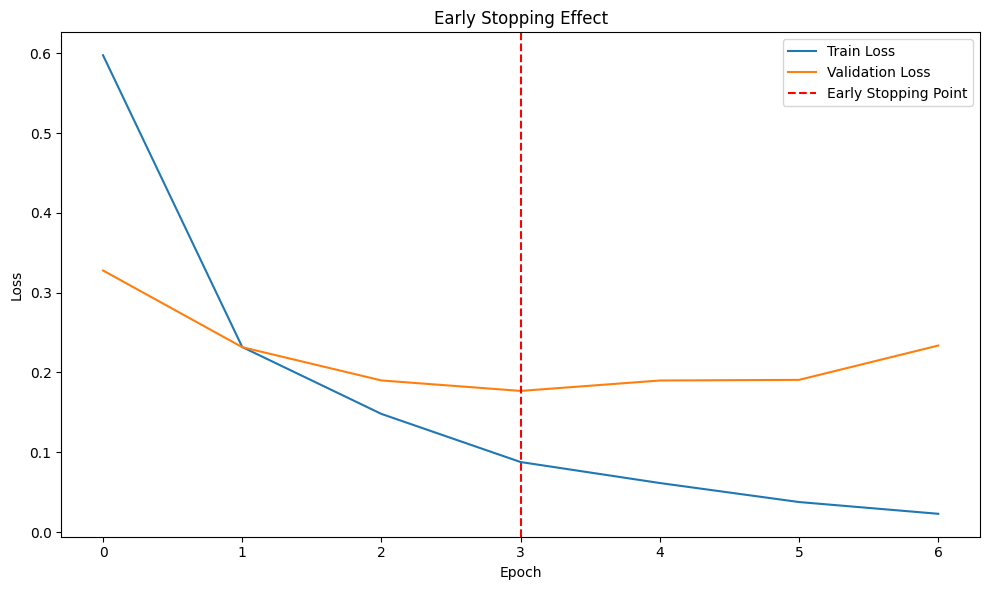

In [57]:
# Early Stopping Visualization
# Create a model that could potentially overfit
early_stopping_model = Sequential([
    Dense(512, input_shape=(784,), activation='relu'),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])

early_stopping_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Train the model with early stopping
early_stopping_history = early_stopping_model.fit(
    X_train_tf[:5000], y_train[:5000],
    validation_data=(X_val_tf[:1000], y_val[:1000]),
    epochs=20,  # Intentionally high to demonstrate early stopping
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Plot training history with early stopping
plt.figure(figsize=(10, 6))
plt.plot(early_stopping_history.history['loss'], label='Train Loss')
plt.plot(early_stopping_history.history['val_loss'], label='Validation Loss')
plt.axvline(x=np.argmin(early_stopping_history.history['val_loss']), color='r', linestyle='--',
            label='Early Stopping Point')
plt.title('Early Stopping Effect')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()